<a href="https://colab.research.google.com/github/Dahuginn/4yr_animerecommend/blob/main/%5BThesis%5Dgraph_split_node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install node2vec
!pip install stellargraph

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx
import stellargraph as sg
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from sklearn.manifold import TSNE

from node2vec import Node2Vec

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn import svm
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV

from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import validation_curve, learning_curve

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')
import pickle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Upload a graph created in the previous notebook

I decided to separate the workflow into two notebooks, because otherwise we could've overloaded colab's RAM. Creating a big df, then turning it into a graph, then training a node2vec model are memory consuming.

In [5]:
fh = open("/content/gdrive/My Drive/4 year/800graph.graphml", "rb")
graph = nx.read_graphml(fh)
nx.info(graph)

'Graph with 399 nodes and 20771 edges'

# Link prediction task

So far we've seen nice pictures of the graph we've created. But how are we going to use it to recommend animes to a user?? We need to formulate the task at hand using the language of machine learning.

We have links that exist in or graph, and we are going to sample the links that do not along with them. The former will be marked as "1", the latter - as "0". For each new pair of animes we are going to predoct whether the link between them could exist - this is the classification task. 
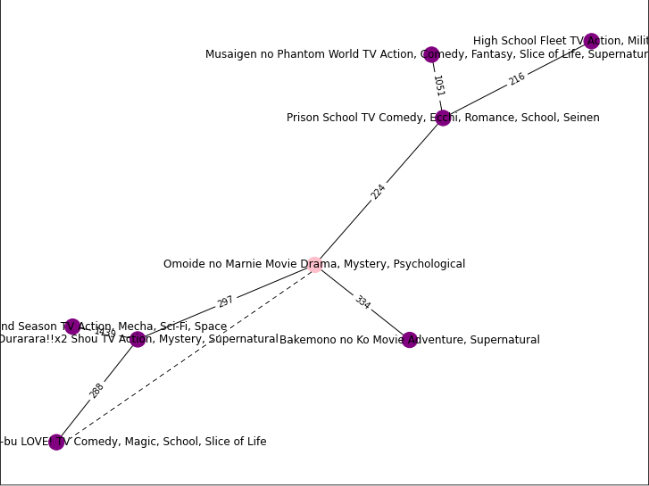

# Train-val-split

In [6]:
edge_splitter_test = EdgeSplitter(graph)
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.05, method="global")

print(nx.info(graph_test))

** Sampled 1038 positive and 1038 negative edges. **
Graph with 399 nodes and 19733 edges


In [7]:
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.05, method="global")
examples_train, examples_model_selection, labels_train, labels_model_selection = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(nx.info(graph_train))

** Sampled 986 positive and 986 negative edges. **
Graph with 399 nodes and 18747 edges


In [8]:
pd.DataFrame(
    [("Training", len(examples_train), "Train classifier"),
      ("Model Selection", len(examples_model_selection), "select the best link classifier model"),
     ("Test", len(examples_test), "evaluate the classifier")],
     columns=("Split", "Num ", "Purpose")).set_index("Split")

,Num,Purpose
Split,,
Training,1479,Train classifier
Model Selection,493,select the best link classifier model
Test,2076,evaluate the classifier


# node2vec models

This will be our working model

In [ ]:
node2vec = Node2Vec(graph_train, dimensions=64, walk_length=30, num_walks=200, workers=4) 
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

In [41]:
def plot_tsne(model):
  ne = model.wv.vectors
  tsne2 = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
  ne_2d = tsne2.fit_transform(ne)
  plt.scatter(ne_2d[:, 0], ne_2d[:, 1])
  plt.show()

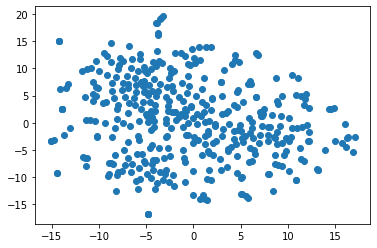

In [42]:
plot_tsne(model)

# node2vec: find similar titles

In [43]:
nodes = []
for i in graph.nodes():
  nodes.append(i)

In [44]:
names_available = np.unique(nodes)

In [45]:
print(names_available[306], model.wv.get_vector(names_available[306]))

Seikai no Senki III OVA Action, Military, Romance, Sci-Fi, Space [-0.1577834   0.11257628 -0.14094381 -0.00428805 -0.02349117 -0.09200122
  0.00045841  0.16182211 -0.04376933  0.07799406 -0.08267222  0.09460983
 -0.03308284  0.32573277 -0.04814479  0.02425468  0.11832643 -0.22418088
  0.09816581  0.20924309 -0.1984271  -0.05356568 -0.14117998  0.38967845
 -0.06327286 -0.0689119   0.0095884   0.08592943  0.35435295 -0.17439169
 -0.09614352  0.16171996  0.1513048   0.06197891 -0.05843273  0.05442822
  0.18625078 -0.23845837 -0.01721119  0.03494554 -0.05444437 -0.07803347
 -0.16752616 -0.07855099 -0.10513537  0.15005662  0.1468147  -0.3127025
  0.05841408  0.04849954 -0.29396275 -0.11529551  0.15259853  0.04585194
 -0.30189642 -0.0573914   0.2535856  -0.21659234 -0.15177232  0.17148969
 -0.07161063 -0.34543973 -0.0085747   0.17065045]


In [46]:
for node, score in model.wv.most_similar('Seikai no Senki III OVA Action, Military, Romance, Sci-Fi, Space'):
  print(node, score)

Iria: Zeiram The Animation OVA Action, Adventure, Sci-Fi, Space 0.6959186792373657
Mezzo DSA TV Action, Adventure, Comedy, Mystery, Sci-Fi 0.6099721193313599
Mahoutsukai ni Taisetsu na Koto: Natsu no Sora TV Drama, Magic, Shounen, Slice of Life 0.5933303833007812
Maburaho TV Comedy, Drama, Ecchi, Harem, Magic, Romance, School 0.58710116147995
Koi Kaze TV Drama, Psychological, Romance, Seinen 0.5815955400466919
Hand Maid May TV Comedy, Ecchi, Harem, Romance, Sci-Fi 0.5797986388206482
Kanon TV Drama, Romance, Slice of Life, Supernatural 0.5591101050376892
Allison to Lillia TV Action, Adventure, Shounen 0.5544236898422241
Mugen no Ryvius TV Drama, Mecha, Military, Psychological, Sci-Fi, Space 0.5490818619728088
Spiral: Suiri no Kizuna TV Drama, Mystery, Shounen 0.5417389869689941


# Classification

In [47]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v): 
    return (u + v) / 2.0

In [10]:
def get_vectorized(link_features, model):
  s = []
  d = []
  for src, dst in link_features:
    s.append(model.wv[src])
    d.append(model.wv[dst])
  return np.array(s), np.array(d)

In [11]:
def apply_operator(s, d, op):
  transformed = op(s, d)
  return transformed

In [12]:
def do_classification(f_train, l_train, op, model):
  s, d = get_vectorized(f_train, model)
  X_train = op(s, d)
  y_train = l_train

  lr_clf = LogisticRegressionCV(Cs=np.logspace(0.01, 1, 5), cv=10, scoring="f1", max_iter=1000)
  pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
  pipa.fit(X_train, y_train)

  return pipa

In [13]:
def evaluate(classif, f_test, l_test, op, model):
  s_test, d_test = get_vectorized(f_test, model)
  testing_labels = apply_operator(s_test, d_test, op)
  predicted = classif.predict_proba(testing_labels)
  predictedf1 = classif.predict(testing_labels)
  positive_column = list(classif.classes_).index(1)
  return f1_score(l_test, predictedf1)
  #return roc_auc_score(l_test, predicted[:, positive_column])

In [14]:
def run_prediction(op, model):
  clf = do_classification(examples_train, labels_train, op, model)
  score = evaluate(clf, examples_model_selection, labels_model_selection, op, model)
  return {
        "classifier": clf,
        "binary_operator": op,
        "score": score
    }

In [72]:
binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [73]:
def show_best_op(model):
  results = [run_prediction(op, model) for op in binary_operators]
  best_result = max(results, key=lambda result: result["score"])

  print(f"Best result from '{best_result['binary_operator'].__name__}'")

  return pd.DataFrame(
      [(result["binary_operator"].__name__, result["score"]) for result in results],
      columns=("name", "f1 score"),
  ).set_index("name"), best_result

In [74]:
res, best_result = show_best_op(model)
res

Best result from 'operator_avg'


,f1 score
name,
operator_hadamard,0.782946
operator_l1,0.792000
operator_l2,0.800789
operator_avg,0.862903


# Evaluation

## Get embeddings

In [ ]:
node2vec_test = Node2Vec(graph_test, dimensions=64, walk_length=30, num_walks=200, workers=4) 
model_test = node2vec_test.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

In [50]:
def plot_tsne_test(model, op):
  s_train, d_train = get_vectorized(examples_model_selection, model)
  s_test, d_test = get_vectorized(examples_test, model)
  X_train = op(s_train, d_train)
  X_test = op(s_test, d_test)
  y_train = labels_model_selection
  y_test = labels_test
    
  ns_probs = [0 for _ in range(len(labels_test))]

  lr_clf = LogisticRegressionCV(Cs=np.logspace(0.01, 1, 5), cv=10, scoring="roc_auc", max_iter=1000)
  pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
  pipa.fit(X_train, y_train)

  lr_probs = lr_clf.predict_proba(X_test)
  lr_probs1 = lr_probs[:, 1]

  # predict class values
  yhat = lr_clf.predict(X_test)

  src_test, dst_test = get_vectorized(examples_test, model)
  test = op(src_test, dst_test)

  tsne2 = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
  ne_2d = tsne2.fit_transform(test)

  plt.scatter(test[:, 0], test[:, 1], c=np.where(yhat == 1, "b", "r"), alpha=0.5)
  plt.show()

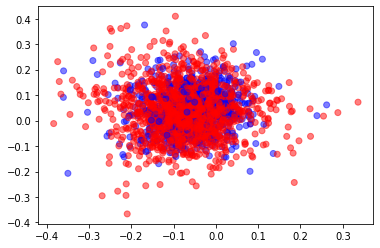

In [51]:
plot_tsne_test(model, best_result["binary_operator"])

In [57]:
s_train, d_train = get_vectorized(examples, model)
s_test, d_test = get_vectorized(examples_test, model)
X_train = best_result["binary_operator"](s_train, d_train)
X_test = best_result["binary_operator"](s_test, d_test)
y_train = labels
y_test = labels_test

In [58]:
lr_clf = LogisticRegressionCV(Cs=np.logspace(0.01, 1, 5), scoring="roc_auc", max_iter=1000)
pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
pipa.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('clf',
                 LogisticRegressionCV(Cs=array([ 1.02329299,  1.80925591,  3.19889511,  5.65587757, 10.        ]),
                                      max_iter=1000, scoring='roc_auc'))])

# Plot ROC-AUC curve

In [66]:
def plot_rocauc(model, op, estimator, title, f_train, l_train, f_test, l_test):

  #roc_auc
  ns_probs = [0 for _ in range(len(l_test))]

  lr_probs = estimator.predict_proba(f_test)
  lr_probs_ = lr_probs[:, 1]

  ns_auc = roc_auc_score(l_test, ns_probs)
  lr_auc = roc_auc_score(l_test, lr_probs_)

  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Logistic: ROC AUC=%.3f' % (lr_auc))

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(l_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(l_test, lr_probs_)

  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)

  # show the legend
  plt.legend()

  # show the plot
  plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.949


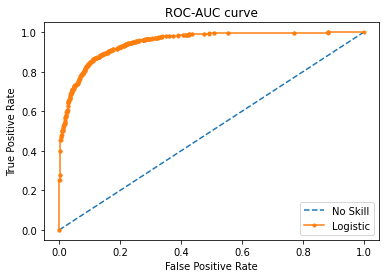

In [67]:
plot_rocauc(model, best_result["binary_operator"], pipa, 'ROC-AUC curve', X_train, y_train, X_test, y_test)

In [ ]:
plt.savefig('/content/gdrive/My Drive/4 year/roccurve.png')

<Figure size 432x288 with 0 Axes>

# Plot Precision-Recall curve

In [68]:
def plot_prc(model, op, estimator, title, f_train, l_train, f_test, l_test):
  ns_probs = [0 for _ in range(len(l_test))]

  lr_probs = estimator.predict_proba(f_test)
  lr_probs_ = lr_probs[:, 1]

  # predict class values
  yhat = lr_clf.predict(f_test)
  lr_precision, lr_recall, _ = precision_recall_curve(l_test, lr_probs_)
  lr_f1, lr_auc, lr_pr, lr_rec = f1_score(l_test, yhat), auc(lr_recall, lr_precision), precision_score(y_test, yhat), recall_score(y_test, yhat)

  # summarize scores
  print('Logistic: f1=%.3f auc=%.3f precision=%.3f recall=%.3f' % (lr_f1, lr_auc, lr_pr, lr_rec))

  # plot the precision-recall curves
  no_skill = len(l_test[l_test==1]) / len(l_test)

  plt.figure(figsize=(10, 8))
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')

  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(title)
  
  # show the legend
  plt.legend()

  # show the plot
  plt.show()

Logistic: f1=0.850 auc=0.950 precision=0.752 recall=0.977


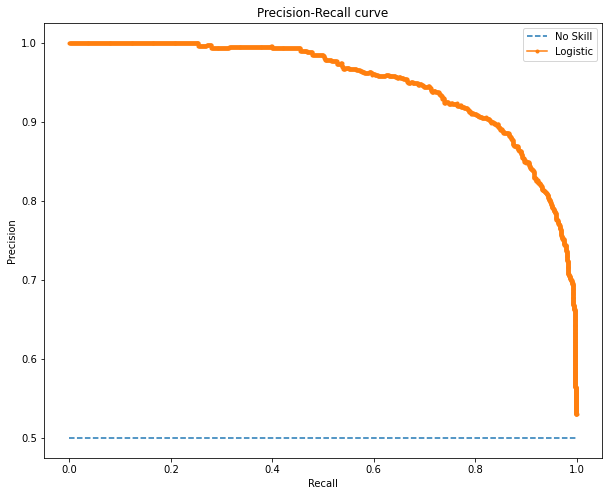

In [69]:
plot_prc(model, best_result["binary_operator"], pipa, 'Precision-Recall curve', X_train, y_train, X_test, y_test)

In [55]:
plt.savefig('/content/gdrive/My Drive/4 year/precreccurve.png')

<Figure size 432x288 with 0 Axes>

# Plot learning curves

In [70]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

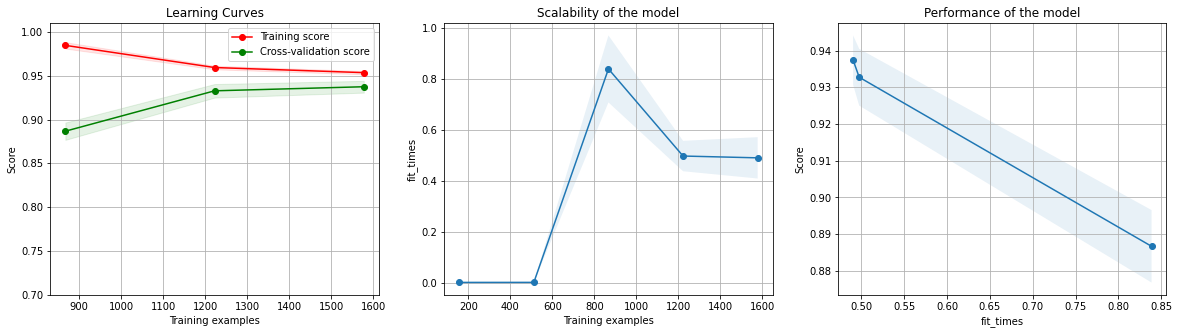

In [71]:
title = "Learning Curves"
plot_learning_curve(pipa, title, X_train, y_train, ylim=(0.7, 1.01), n_jobs=4)
plt.show()

# Dump'n'Load

Train

In [ ]:
pickle.dump(model, open('/content/gdrive/My Drive/4 year/final_node2vec_800.sav', 'wb'))

In [3]:
model = pickle.load(open('/content/gdrive/My Drive/4 year/final_node2vec_800.sav', 'rb'))

Test

In [ ]:
pickle.dump(model_test, open('/content/gdrive/My Drive/4 year/final_node2vec_test800.sav', 'wb'))

In [4]:
model_test = pickle.load(open('/content/gdrive/My Drive/4 year/final_node2vec_test800.sav', 'rb'))